In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import fuzzywuzzy
from fuzzywuzzy import process
import chardet
import collections
from collections import Counter

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('./final_Nov_09.csv')
df.shape

(2283, 11)

In [3]:
df.head()

,Name,Current_Company,Current_Job,Total_year,job_location,Last_degree,Graduation_start_year,Graduation_end_year,Last_University,ProfileIDS,skills
0,Abrar Javed,Upwork,Professional Freelancer,Sep 2020 – Present,Pakistan,BS electrical engineering,2015,2020,National University of Computer and Emerging S...,/in/abrar-javed-49854b14b/,Management||Microsoft Excel||Customer Service|...
1,Mahrukh Fatima,DevBunch Private Limited,Project Coordinator,Oct 2021 – Present,"Lahore, Pakistan",Bachelor of Business Administration (BBA),2014,2018,National University of Computer and Emerging S...,/in/mahrukh-fatima-60b863106/,Microsoft Office||Customer Service||Microsoft ...
2,Neha Nadeem,Daraz,Data Analyst,Dec 2020 – Present,"Los Angeles, California, United States",BS(CS),2016,2020,National University of Computer and Emerging S...,/in/nehanadeem/,Business Intelligence (BI)||Data Analysis||Dat...
3,Abdul Rafeh,No Joke Marketing,Corporate Marketing Manager,Oct 2021 – Present,United States,Master's degree,2017,2018,National University of Computer and Emerging S...,/in/rafeh11/,Microsoft Office||Microsoft Excel||PowerPoint|...
4,Areeba Ayyaz,KeepTruckin,Software Engineer- Backend,Nov 2020 – Present,"Lahore, Punjab, Pakistan",Bachelor of Science in Computer Science,2016,2020,National University of Computer and Emerging S...,/in/areeba-ayyaz-6948071a3/,Java||Ruby on Rails||Problem Solving||Android ...


# Handling Missing Values:

In [4]:
# % of values missing in each column
values_list = list()
cols_list = list()
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())*100
    cols_list.append(col)
    values_list.append(pct_missing)
pct_missing_df = pd.DataFrame()
pct_missing_df['col'] = cols_list
pct_missing_df['pct_missing'] = values_list
pct_missing_df['pct_missing']

0      0.219010
1      4.993430
2     20.105125
3      2.058695
4      8.935611
5      1.576873
6      1.795883
7      2.584319
8      0.219010
9      0.087604
10     5.387648
Name: pct_missing, dtype: float64

In [5]:
#we will replace missing values with the mode values of that column.
df_non_numeric = df.select_dtypes(exclude=[np.number]) 
non_numeric_cols = df_non_numeric.columns.values
for col in non_numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  # impute values only for columns that have missing values
        mod = df[col].describe()['top'] # impute with the most frequently occuring value
        df[col] = df[col].fillna(mod)

#we will replace missing values with the median values of that column.
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  # impute values only for columns that have missing values
        med = df[col].median() #impute with the median
        df[col] = df[col].fillna(med)
df.isnull().sum().sum()

0

# Duplicate records

In [6]:
# dropping duplicate profile urls from  ProfileIDS Column
profile_urls = list(df.columns)[-2]
df.drop_duplicates(subset=profile_urls, inplace=True)
df.shape

(2253, 11)

In [7]:
df['Name'] = df['Name'].str.lower()
df['Name'] = df['Name'].str.strip()
df['Current_Company'] = df['Current_Company'].str.lower()
df['Current_Company'] = df['Current_Company'].str.strip()
df['Current_Job'] = df['Current_Job'].str.lower()
df['Current_Job'] = df['Current_Job'].str.strip()
df['job_location'] = df['job_location'].str.lower()
df['job_location'] = df['job_location'].str.strip()
df['Last_degree'] = df['Last_degree'].str.lower()
df['Last_degree'] = df['Last_degree'].str.strip()
df['Last_University'] = df['Last_University'].str.lower()
df['Last_University'] = df['Last_University'].str.strip()
df['Total_year'] = df['Total_year'].str.lower()
df['Total_year'] = df['Total_year'].str.strip()
df['Graduation_start_year'] = df['Graduation_start_year'].str.lower()
df['Graduation_start_year'] = df['Graduation_start_year'].str.strip()
df['Graduation_end_year'] = df['Graduation_end_year'].str.lower()
df['Graduation_end_year'] = df['Graduation_end_year'].str.strip()
df['skills'] = df['skills'].str.lower()
df['skills'] = df['skills'].str.strip()


# Correcting Inconsistencies

In [8]:
#There were many different words in the responses which referred to the same term, so we grouped them in a single word.
#Typos and mis-spelling were corrected.
#Finally, punctuation such as commas, apostrophes, quotes, question marks and others was removed.

In [12]:

# Function to identify degree
def degree(x):
    if x.find('bachelor') != -1 or x.find("bachelor's") != -1 or x.find('b.s') != -1 or x.find('bs') != -1 or x.find('bs.') != -1 or x.find('bachelors') != -1 or x.find('undergraduate') != -1 or x.find('graduated')!= -1 or x.find('bse')!= -1 or x.find('bcs') != -1:
        result = 'bachelor degree'
        return result        
    if x.find('master') != -1 or x.find("master's") != -1 or x.find('m.s') != -1 or x.find('ms') != -1 or x.find('mphil') != -1 or x.find('mba') != -1 or x.find('micromasters') != -1 or x.find('msc') != -1 or x.find('mscs') !=-1 or x.find('msds')!=-1or x.find('master of engineering') != -1:
        result = 'master degree'
        return result        
    if x.find('phd') != -1 or x.find('p.hd') != -1 or x.find('ph.d') != -1 or x.find('doctor') != -1:
        result = 'phd degree'
        return result       
    else:
        result = 'others degree'
        return result

df['degree'] = list(map(degree, df['Last_degree'].astype(str)))# Create degree column


In [13]:
df['skills'] = df['skills'].apply(lambda x: x.replace("||", ","))

df['Last_University'] = df['Last_University'].apply(lambda x: x.replace("national university of computer and emerging sciences", "fast nuces"))
df['Current_Company'] = df['Current_Company'].apply(lambda x: x.replace("national university of computer and emerging sciences", "fast nuces"))


df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bs", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("ms", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("mphil", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("cs", "computer science"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("conputer", "computer"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("(ee)", "electrical engineering"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("(te)", "electrical engineering"))

df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("(af)", "business adminintration"))

df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bachelor's", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bachelora's degree", "bachelor"))

df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bachelor’s", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bachelors", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("b.s", "bachelor"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("bba", "bachelor of business adminintration"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("mastera's", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("master's", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("master’s degree", "master"))

df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("masters", "master"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("phd", "doctor of philosophy"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("mba", "master of business adminintration"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("accounting and finance", "business adminintration"))
df['Last_degree'] = df['Last_degree'].apply(lambda x: x.replace("spm", "software project management"))


df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor of computer science' if 'bachelor' in x and 'computer' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor electrical engineering' if 'bachelor' in x and 'electrical' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor electrical engineering' if 'bachelor' in x and 'telecommunication' in x else x) 

df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor of business administration' if 'bachelor' in x and 'administration' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'bachelor of business administration' if 'bachelor' in x and 'finance' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'master of computer science' if 'master' in x and 'computer' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'master of computer science' if 'master' in x and 'technology' in x else x)

df.Last_degree = df.Last_degree.apply(lambda x: 'master of business administration' if 'master' in x and 'administration' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'master of software project management' if 'master' in x and 'project' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'doctor of philosophy' if 'postgradua' in x else x)
df.Last_degree = df.Last_degree.apply(lambda x: 'doctor of philosophy' if 'doctor' in x else x)

In [14]:
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*computer.*$)', 'bachelor of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*electrical.*$)','bachelor electrical engineering')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*administration.*$)','bachelor of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*finance.*$)','bachelor of business administration')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*administration.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and'(^.*computer.*$)', 'master of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and'(^.*technology.*$)', 'master of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and'(^.*project.*$)', 'master of software project management')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*postgradua.*$)'or'(^.*philoso.*$)', 'doctor of philosophy')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*doctor.*$)', 'doctor of philosophy')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*computer.*$)', 'bachelor of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*engineering.*$)', 'bachelor of electrical engineering')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor of science.*$)'or "(^.*bachelora's degree.*$)", 'bachelor degree')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*administration.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*business.*$)'or '(^.*finance.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*information.*$)'or '(^.*technology.*$)'or '(^.*comput.*$)', 'master of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*masters of science.*$)'or '(^.*master in science.*$)', 'master degree')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*project .*$)', 'master of project managment')


df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*computer.*$)', 'bachelor of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*engineering.*$)', 'bachelor of electrical engineering')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor of science.*$)'or "(^.*bachelora's degree.*$)", 'bachelor degree')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*administration.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*business.*$)'or '(^.*finance.*$)', 'master of business administration')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*information.*$)'or '(^.*technology.*$)'or '(^.*comput.*$)', 'master of computer science')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*masters of science.*$)'or '(^.*master in science.*$)', 'master degree')
df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master.*$)'and '(^.*project .*$)', 'master of project managment')

df['Last_degree'] = df.Last_degree.str.replace(r'(^.*master of science.*$)', 'master degree')

<ipython-input-14-b14e07ecae2c>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*computer.*$)', 'bachelor of computer science')
<ipython-input-14-b14e07ecae2c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*electrical.*$)','bachelor electrical engineering')
<ipython-input-14-b14e07ecae2c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*administration.*$)','bachelor of business administration')
<ipython-input-14-b14e07ecae2c>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Last_degree'] = df.Last_degree.str.replace(r'(^.*bachelor.*$)'and '(^.*finance.*$)','bache

In [17]:
degree_name=df['Last_degree'].unique()
degree_name.sort()
len(degree_name)
#degree_name

127

In [20]:
#df['skills'] = df['skills'].apply(lambda x: x.replace("||", ","))
#import pandas as pd
#df = pd.read_csv('final_Nov_09.csv' , header=0 )
ary=[]
ary=df.Total_year.to_list()
#print(df)
new_ary=[]
months=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

n=0
f=0
for i in ary:
    #print (i)
    
    n=n+1
    strs=i
    if isinstance(strs, float):  # handling no value
        strs=0
        #print (0)
        new_ary.append(0)
        f=f+1
        continue
        
    if len(strs)<10:          #handling less value or error
        #print (0)
        new_ary.append(0)
        f=f+1
        continue
    strs=strs.lower()
    i2=strs.split()
    #print ('iiiiii2',i2)
    m=0
    z=f
   
    for x in months:     #
        yy=2020
        a=11
        m=m+1
        if i2[0]==x:
            y=int(i2[1])
            j=0
            if i2[3]!="present":
                for xx in months:
                    j=j+1
                    if i2[3]==x:
                        a=j
                        yy=int(i2[4])
                        continue
            y=yy-y    
            if m<=a:
                y=y+1
            if y==0:
                y=1
            #print (y)    
            new_ary.append(y)
            
            f=f+1
            continue
  
    if (z==f):
            y=1
            #print (1)
            new_ary.append(1)
            continue
#print (new_ary)                
#print (len(new_ary))

df1 = pd.DataFrame(new_ary,columns=['Total_year'])
df['Total_year'] = df1['Total_year']
print (df)

,Name,Current_Company,Current_Job,Total_year,job_location,Last_degree,Graduation_start_year,Graduation_end_year,Last_University,ProfileIDS,skills,degree
0,abrar javed,upwork,professional freelancer,0.0,pakistan,bachelor of electrical engineering,2015,2020,fast nuces,/in/abrar-javed-49854b14b/,"management,microsoft excel,customer service,st...",bachelor degree
1,mahrukh fatima,devbunch private limited,project coordinator,0.0,"lahore, pakistan",master of business administration,2014,2018,fast nuces,/in/mahrukh-fatima-60b863106/,"microsoft office,customer service,microsoft ex...",bachelor degree
2,neha nadeem,daraz,data analyst,0.0,"los angeles, california, united states",bachelor of computer science,2016,2020,fast nuces,/in/nehanadeem/,"business intelligence (bi),data analysis,data ...",bachelor degree
3,abdul rafeh,no joke marketing,corporate marketing manager,0.0,united states,master degree,2017,2018,fast nuces,/in/rafeh11/,"microsoft office,microsoft excel,powerpoint,re...",master degree
4,areeba ayyaz,keeptruckin,software engineer- backend,0.0,"lahore, punjab, pakistan",bachelor of computer science,2016,2020,fast nuces,/in/areeba-ayyaz-6948071a3/,"java,ruby on rails,problem solving,android dev...",bachelor degree
...,...,...,...,...,...,...,...,...,...,...,...,...
2278,agha hamza waheed,carfirst,area manager purchase,NaN,"lahore, pakistan",bachelor degree,2012,2017,fast nuces,/in/agha-hamza-waheed-bb2384b1/,"microsoft office,team management,auditing,fina...",bachelor degree
2279,mian muhammad faizan elahi,tkxel,sales development representative,NaN,"lahore, punjab, pakistan",master of business administration,2020,2022,lahore school of economics,/in/mian-muhammad-faizan-elahi/,"business analytics,digital marketing,search en...",master degree
2280,ali sulehria,rdx sports,amazon content manager,NaN,pakistan,master of business administration,2019,2021,bahria university,/in/ali-sulehria-1661a026/,none,master degree
2281,hajra arshad,online,freelance writer,NaN,"islamabad, islamabad, pakistan",master of business administration,2020,2022,institute of business administration,/in/hajra-arshad/,"adobe photoshop,microsoft excel,microsoft word...",master degree


In [21]:
df['job_location'] = df.job_location.str.replace(r'(^.*lahore.*$)', 'lahore pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*faisalabad.*$)', 'faisalabad Pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*multan.*$)', 'multan Pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*sialkot.*$)', 'sialkot Pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*gilgit.*$)', 'gilgit Pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*kar.*$)', 'karachi pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*islam.*$)', 'islamabad pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*rawalpindi.*$)', 'islamabad pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*quetta.*$)', 'quetta pakistan')
df['job_location'] = df.job_location.str.replace(r'(^.*united states.*$)', 'united states')
df['job_location'] = df.job_location.str.replace(r'(^.*canada.*$)', 'canada')
df['job_location'] = df.job_location.str.replace(r'(^.*peshawar.*$)'or'(^.*khyber pakhtunkhwa.*$)' , 'peshawar') 
df['job_location'] = df.job_location.str.replace(r'(^.*khyber pakhtunkhwa.*$)' , 'peshawar')
df.Last_degree = df.Last_degree.apply(lambda x: 'pakistan' if 'pakistan' in x and  'peshawar' != x and  'lahore' != x and  'faisalabad' != x and  'karachi' != x and  'rawalpindi' != x and  'quetta' != x and  'islam' != x and  'sialkot' != x and  'multan' != x and  'karachi' != x and  'rawalpindi' != x and  'quetta' != x else x)


<ipython-input-21-7abec0ef4560>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['job_location'] = df.job_location.str.replace(r'(^.*lahore.*$)', 'lahore pakistan')
<ipython-input-21-7abec0ef4560>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['job_location'] = df.job_location.str.replace(r'(^.*faisalabad.*$)', 'faisalabad Pakistan')
<ipython-input-21-7abec0ef4560>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['job_location'] = df.job_location.str.replace(r'(^.*multan.*$)', 'multan Pakistan')
<ipython-input-21-7abec0ef4560>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['job_location'] = df.job_location.str.replace(r'(^.*sialkot.*$)', 'sialkot Pakistan')
<ipython-input-21-7abec0ef4560>:5: FutureWarning: The default value of regex will change from True to False in a futur

In [22]:
df['job_location'].value_counts(normalize=True) * 100

lahore pakistan                                  36.839769
karachi pakistan                                 22.725255
pakistan                                         10.075455
islamabad pakistan                                6.480249
islamabad, pakistan                               5.237461
                                                   ...    
mea & apac                                        0.044385
https://web.facebook.com/gosquashassociation/     0.044385
finland                                           0.044385
sheikhupura                                       0.044385
none                                              0.044385
Name: job_location, Length: 138, dtype: float64

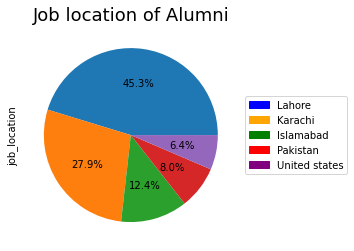

In [23]:
pie = df['job_location'].value_counts().nlargest(5).plot(kind="pie", autopct='%1.1f%%', labels=None)
pie.set_title("Job location of Alumni", fontsize=18)

lahore = mpatches.Patch(color='blue', label='Lahore')
karachi = mpatches.Patch(color='orange', label='Karachi')
islamabad  = mpatches.Patch(color='green', label='Islamabad')
pakistan = mpatches.Patch(color='red', label='Pakistan')
unitedstates = mpatches.Patch(color='purple', label='United states')

plt.legend(handles=[lahore,karachi,islamabad,pakistan,unitedstates], loc='center left', bbox_to_anchor=(1, 0.5))

Text(0, 0.5, '# of Alumni')

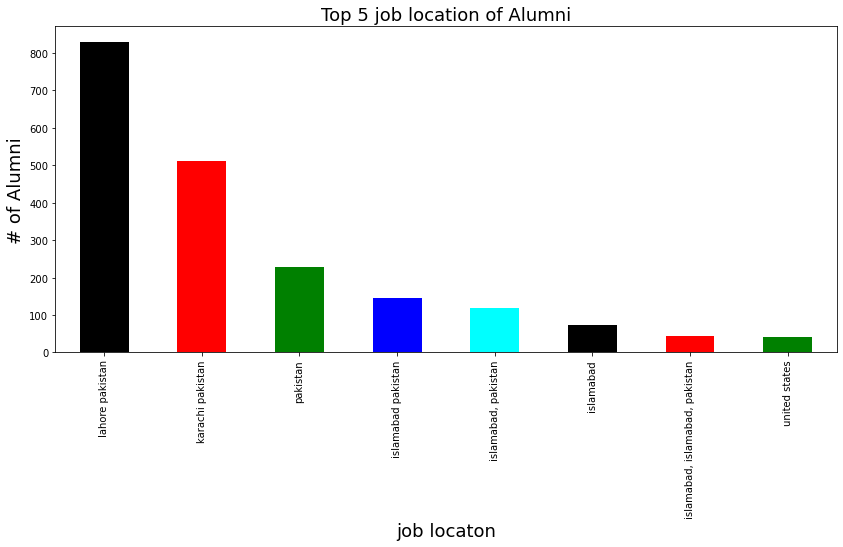

In [24]:
bar1 = df['job_location'].value_counts().nlargest(8).plot(kind="bar",figsize=(14,6),color=['black', 'red', 'green', 'blue', 'cyan'])
bar1.set_title("Top 5 job location of Alumni", fontsize=18)
bar1.set_xlabel("job locaton", fontsize=18);
bar1.set_ylabel("# of Alumni", fontsize=18)


In [787]:
loc=df['job_location'].unique()
loc.sort()
len(loc)
#loc

138

In [789]:
# look at the first ten thousand bytes to guess the character encoding
with open("./final_Nov_09.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100))

# check what the character encoding might be
print(result)

{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}


In [790]:
df = pd.read_csv('./final_Nov_09 (3).csv')
df.shape

(2281, 11)

In [26]:
# get all the unique values in the 'City' column
Current_Job = df['Current_Job'].unique()

# sort them alphabetically and then take a closer look

len(Current_Job)

872

In [27]:
jobs = ['Software engineer', 'Software Developer',
'freelancer',
'Full-stack developer',
'Front end developer','Back end developer','Blockchain Engineer','Cloud Architect','Java developer','DevOps engineer',
'UX designer',
'Web Developer',
'Security Analyst',
'Project Manager',
'Data scientist',
'data analyst','Data Engineer',
'Business analyst',
'Robotics Engineer',
'Cloud computing engineer',
'Software quality assurance',
'machine learning engineer',
'AI Engineer',
'Mobile App Developer', 
'Game Developer',
'Computer Programmer',
'Database Administrator',
'Computer Network Architect',
'Network Administrator',
'Information Researcher',
]

In [28]:
def find_min_ratio(matches):
    list_of_jobs = []
    for i in matches:
        if i[1] > 70 and i[1] < 100:
            list_of_jobs.append(i[1])
    if len(list_of_jobs) == 0 or len(list_of_jobs) == 1:
        return 0
    else: 
        list_of_jobs = Counter(list_of_jobs)
        common_elements = list_of_jobs.most_common(5)
        last_tuple = min(common_elements,key=lambda item:(-item[1], item[0]))
        min_ratio = last_tuple[0]
        return min_ratio

In [29]:
def replace_matches_in_column(matches, string_to_match, df, column, min_ratio = 70):
    strings = df[column].unique()
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    rows_with_matches = df[column].isin(close_matches)

    df.loc[rows_with_matches, column] = string_to_match

In [30]:
def replace_matches_in_column(matches, string_to_match, df, column, min_ratio = 70):
    strings = df[column].unique()
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    rows_with_matches = df[column].isin(close_matches)

    df.loc[rows_with_matches, column] = string_to_match

In [33]:
loc=df['job_location'].unique()
len(loc)


138

In [799]:
df.to_csv('./final_Nov.csv')


# Data Cleaning Challenge: Inconsistent Data Entry

# Use fuzzy matching to correct inconsistent data entry